# Smol Multimodal RAG: Building with ColSmolVLM and SmolVLM on Colab's Free-Tier GPU

_Authored by: [Sergio Paniego](https://github.com/sergiopaniego)_


In this notebook, we go **smol** 🤏 and demonstrate how to build a **Multimodal Retrieval-Augmented Generation (RAG)** system by integrating [**ColSmolVLM**](https://huggingface.co/vidore/colsmolvlm-alpha) for document retrieval and [**SmolVLM**](https://huggingface.co/blog/smolvlm/) as the vision-language model (VLM). These lightweight models enable us to run a fully functional multimodal RAG system on consumer GPUs and even on the Google Colab free-tier.

This notebook is the third installment in the **Multimodal RAG Recipes** series. If you're new to the topic or want to explore more, check out these previous recipes:

- [Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms)
- [Multimodal RAG with ColQwen2, Reranker, and Quantized VLMs on Consumer GPUs](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_reranker_and_vlms)

Let's dive in and build a powerful yet compact RAG system! 🚀


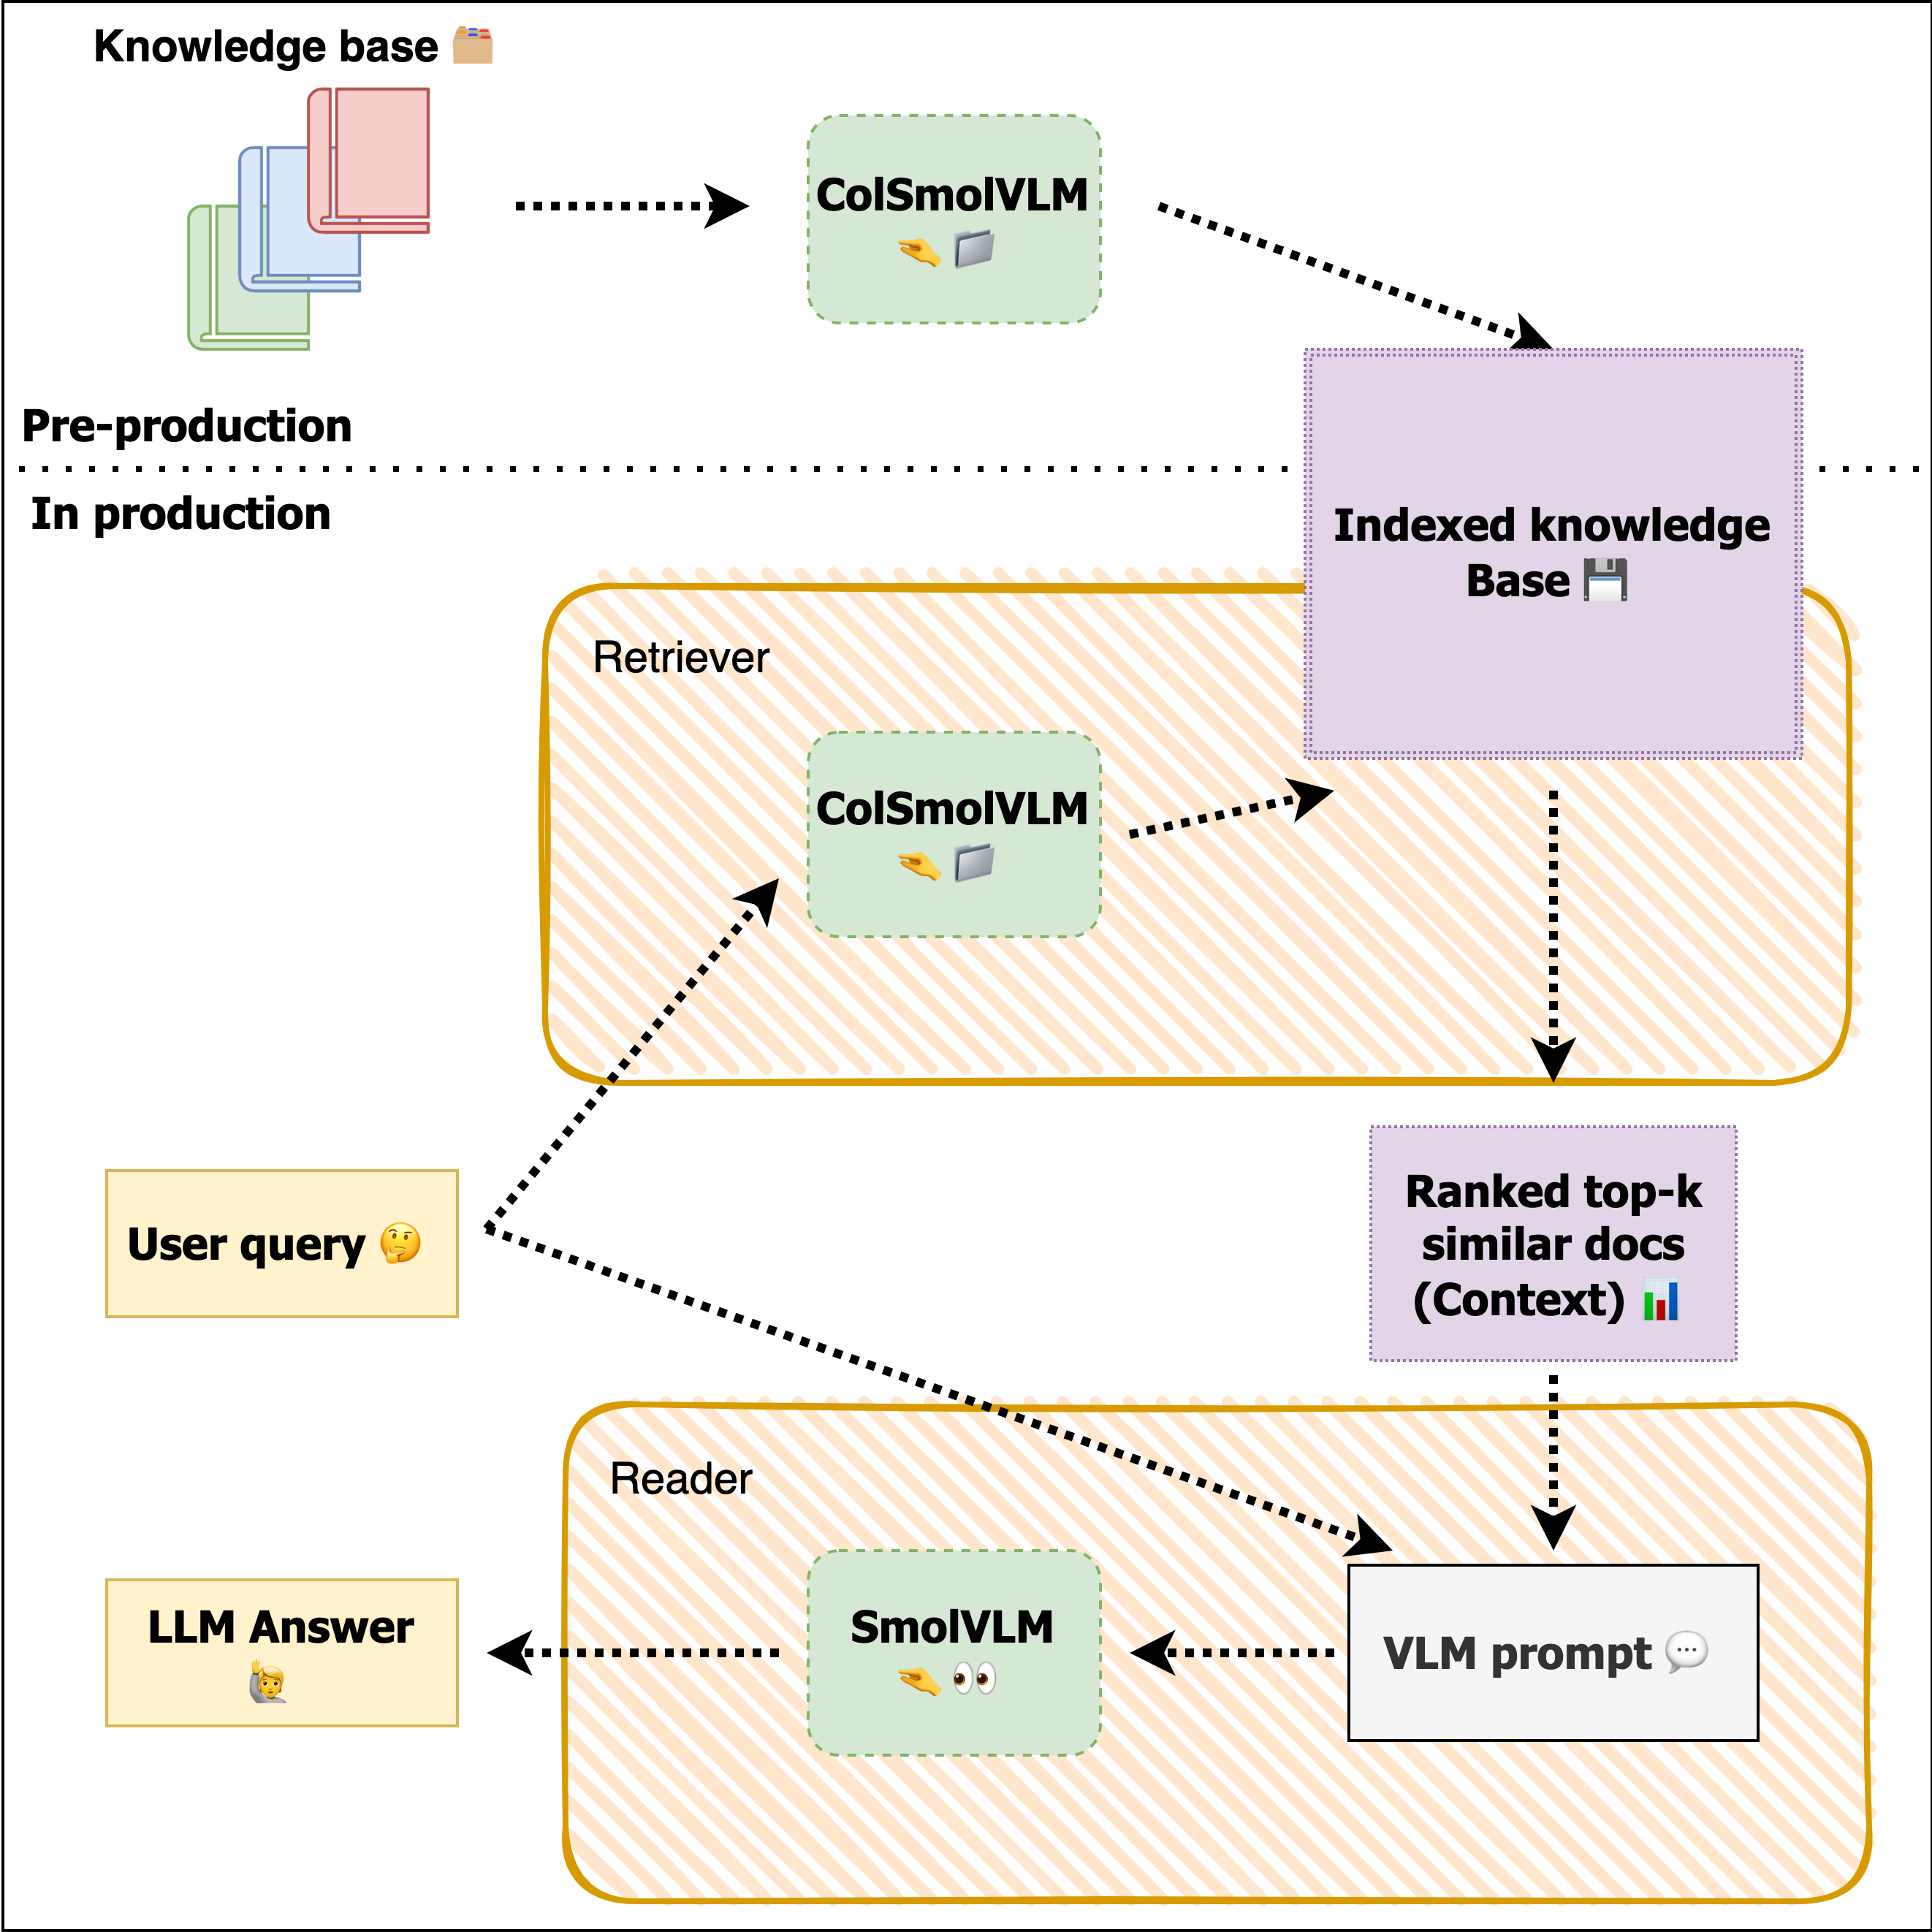

## 1. Install dependencies

Let’s kick off by installing the essential libraries for our project! 🚀

For this notebook, we’ll need to download a **work-in-progress PR** of [byaldi](https://github.com/sergiopaniego/byaldi). Once the [PR](https://github.com/AnswerDotAI/byaldi/pull/69) is merged, these installation steps can be updated accordingly.

In [ ]:
!pip install -q git+https://github.com/sergiopaniego/byaldi.git@colsmolvlm-support

## 2. Load Dataset 📁

In this notebook, we’ll use charts and maps from [Our World in Data](https://ourworldindata.org/), an open-access platform offering a wealth of data and visualizations. Our focus will be on the [life expectancy data](https://ourworldindata.org/life-expectancy), which provides insights into global trends in life expectancy over time.

To simplify access and keep things smol 🤏, we’ve curated a subset of this data into a [dataset hosted on Hugging Face](https://huggingface.co/datasets/sergiopaniego/ourworldindata_example). This small collection is ideal for demonstration, but in practical applications, you could scale up to a much larger dataset to enhance the system’s performance.

**Citation:**

```
Saloni Dattani, Lucas Rodés-Guirao, Hannah Ritchie, Esteban Ortiz-Ospina and Max Roser (2023) - “Life Expectancy” Published online at OurWorldinData.org. Retrieved from: 'https://ourworldindata.org/life-expectancy' [Online Resource]
```


In [4]:
from datasets import load_dataset

dataset = load_dataset("sergiopaniego/ourworldindata_example", split='train')

After downloading the visual data, we’ll save it locally to prepare it for the RAG (Retrieval-Augmented Generation) system. This step is essential, as it enables the document retrieval model (ColSmolVLM) to efficiently index, process, and manipulate the visual content. Proper indexing ensures seamless integration and retrieval during system execution.

In [ ]:
import os
from PIL import Image

def save_images_to_local(dataset, output_folder="data/"):
    os.makedirs(output_folder, exist_ok=True)

    for image_id, image_data in enumerate(dataset):
        image = image_data['image']

        if isinstance(image, str):
            image = Image.open(image)

        output_path = os.path.join(output_folder, f"image_{image_id}.png")

        image.save(output_path, format='PNG')

        print(f"Image saved in: {output_path}")

save_images_to_local(dataset)

Now, let’s load the images to explore the dataset and get a quick overview of the visual content we’ll be working with. This step helps us familiarize ourselves with the data and ensures everything is set up correctly for the next stages.  

In [6]:
import os
from PIL import Image

def load_png_images(image_folder):
    png_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
    all_images = {}

    for image_id, png_file in enumerate(png_files):
        image_path = os.path.join(image_folder, png_file)
        image = Image.open(image_path)
        all_images[image_id] = image

    return all_images

all_images = load_png_images("/content/data/")

Let’s visualize a few samples to get an understanding of how the data is structured! This will help us grasp the format and layout of the content we’ll be working with. 👀

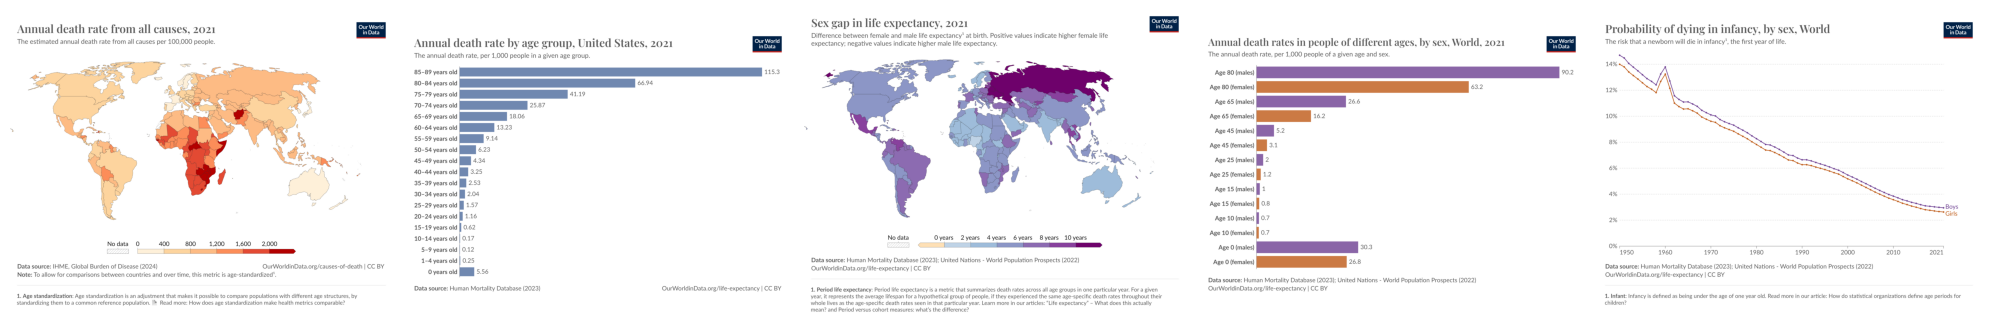

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 15))

for i, ax in enumerate(axes.flat):
    img = all_images[i]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 3. Initialize the ColSmolVLM Multimodal Document Retrieval Model 🤖

Now that our dataset is ready, it’s time to initialize the **Document Retrieval Model**, which will extract relevant information from the raw images and return the appropriate documents based on our queries. This model plays a crucial role in enhancing our system’s conversational capabilities by enabling precise information retrieval.

For this task, we will use **[Byaldi](https://github.com/AnswerDotAI/byaldi)**, a library designed to streamline multimodal RAG pipelines. Byaldi provides APIs that integrate multimodal retrievers and vision-language models for efficient retrieval-augmented generation workflows.

In this notebook, we will focus specifically on **ColSmolVLM**.

![ColPali architecture](https://github.com/illuin-tech/colpali/blob/main/assets/colpali_architecture.webp?raw=true)

Additionally, you can explore **[ViDore (The Visual Document Retrieval Benchmark)](https://huggingface.co/spaces/vidore/vidore-leaderboard)** to see top-performing retrievers in action.



First, we will load the model from the checkpoint.


In [ ]:
from byaldi import RAGMultiModalModel

docs_retrieval_model = RAGMultiModalModel.from_pretrained("vidore/colsmolvlm-alpha")

Next, we’ll index our documents using the document retrieval model by specifying the folder where the images are stored. This process allows the model to efficiently organize and process the documents, ensuring they can be quickly retrieved based on our queries.

In [ ]:
docs_retrieval_model.index(
    input_path="data/",
    index_name="image_index",
    store_collection_with_index=False,
    overwrite=True
)

## 4. Retrieving Documents with the Document Retrieval Model 🤔

Now that the document retrieval model is initialized, we can test its capabilities by submitting a question and getting relevant documents that might contain the answer.

The model will rank the results by relevance, returning the most pertinent documents first.

Let’s give it a try and see how well it performs!


In [10]:
text_query = 'What is the overall trend in life expectancy across different countries and regions?'

results = docs_retrieval_model.search(text_query, k=1)
results

[{'doc_id': 5, 'page_num': 1, 'score': 22.0, 'metadata': {}, 'base64': None}]

Let’s take a look at the retrieved document and check whether the model has correctly matched our query with the best possible results.

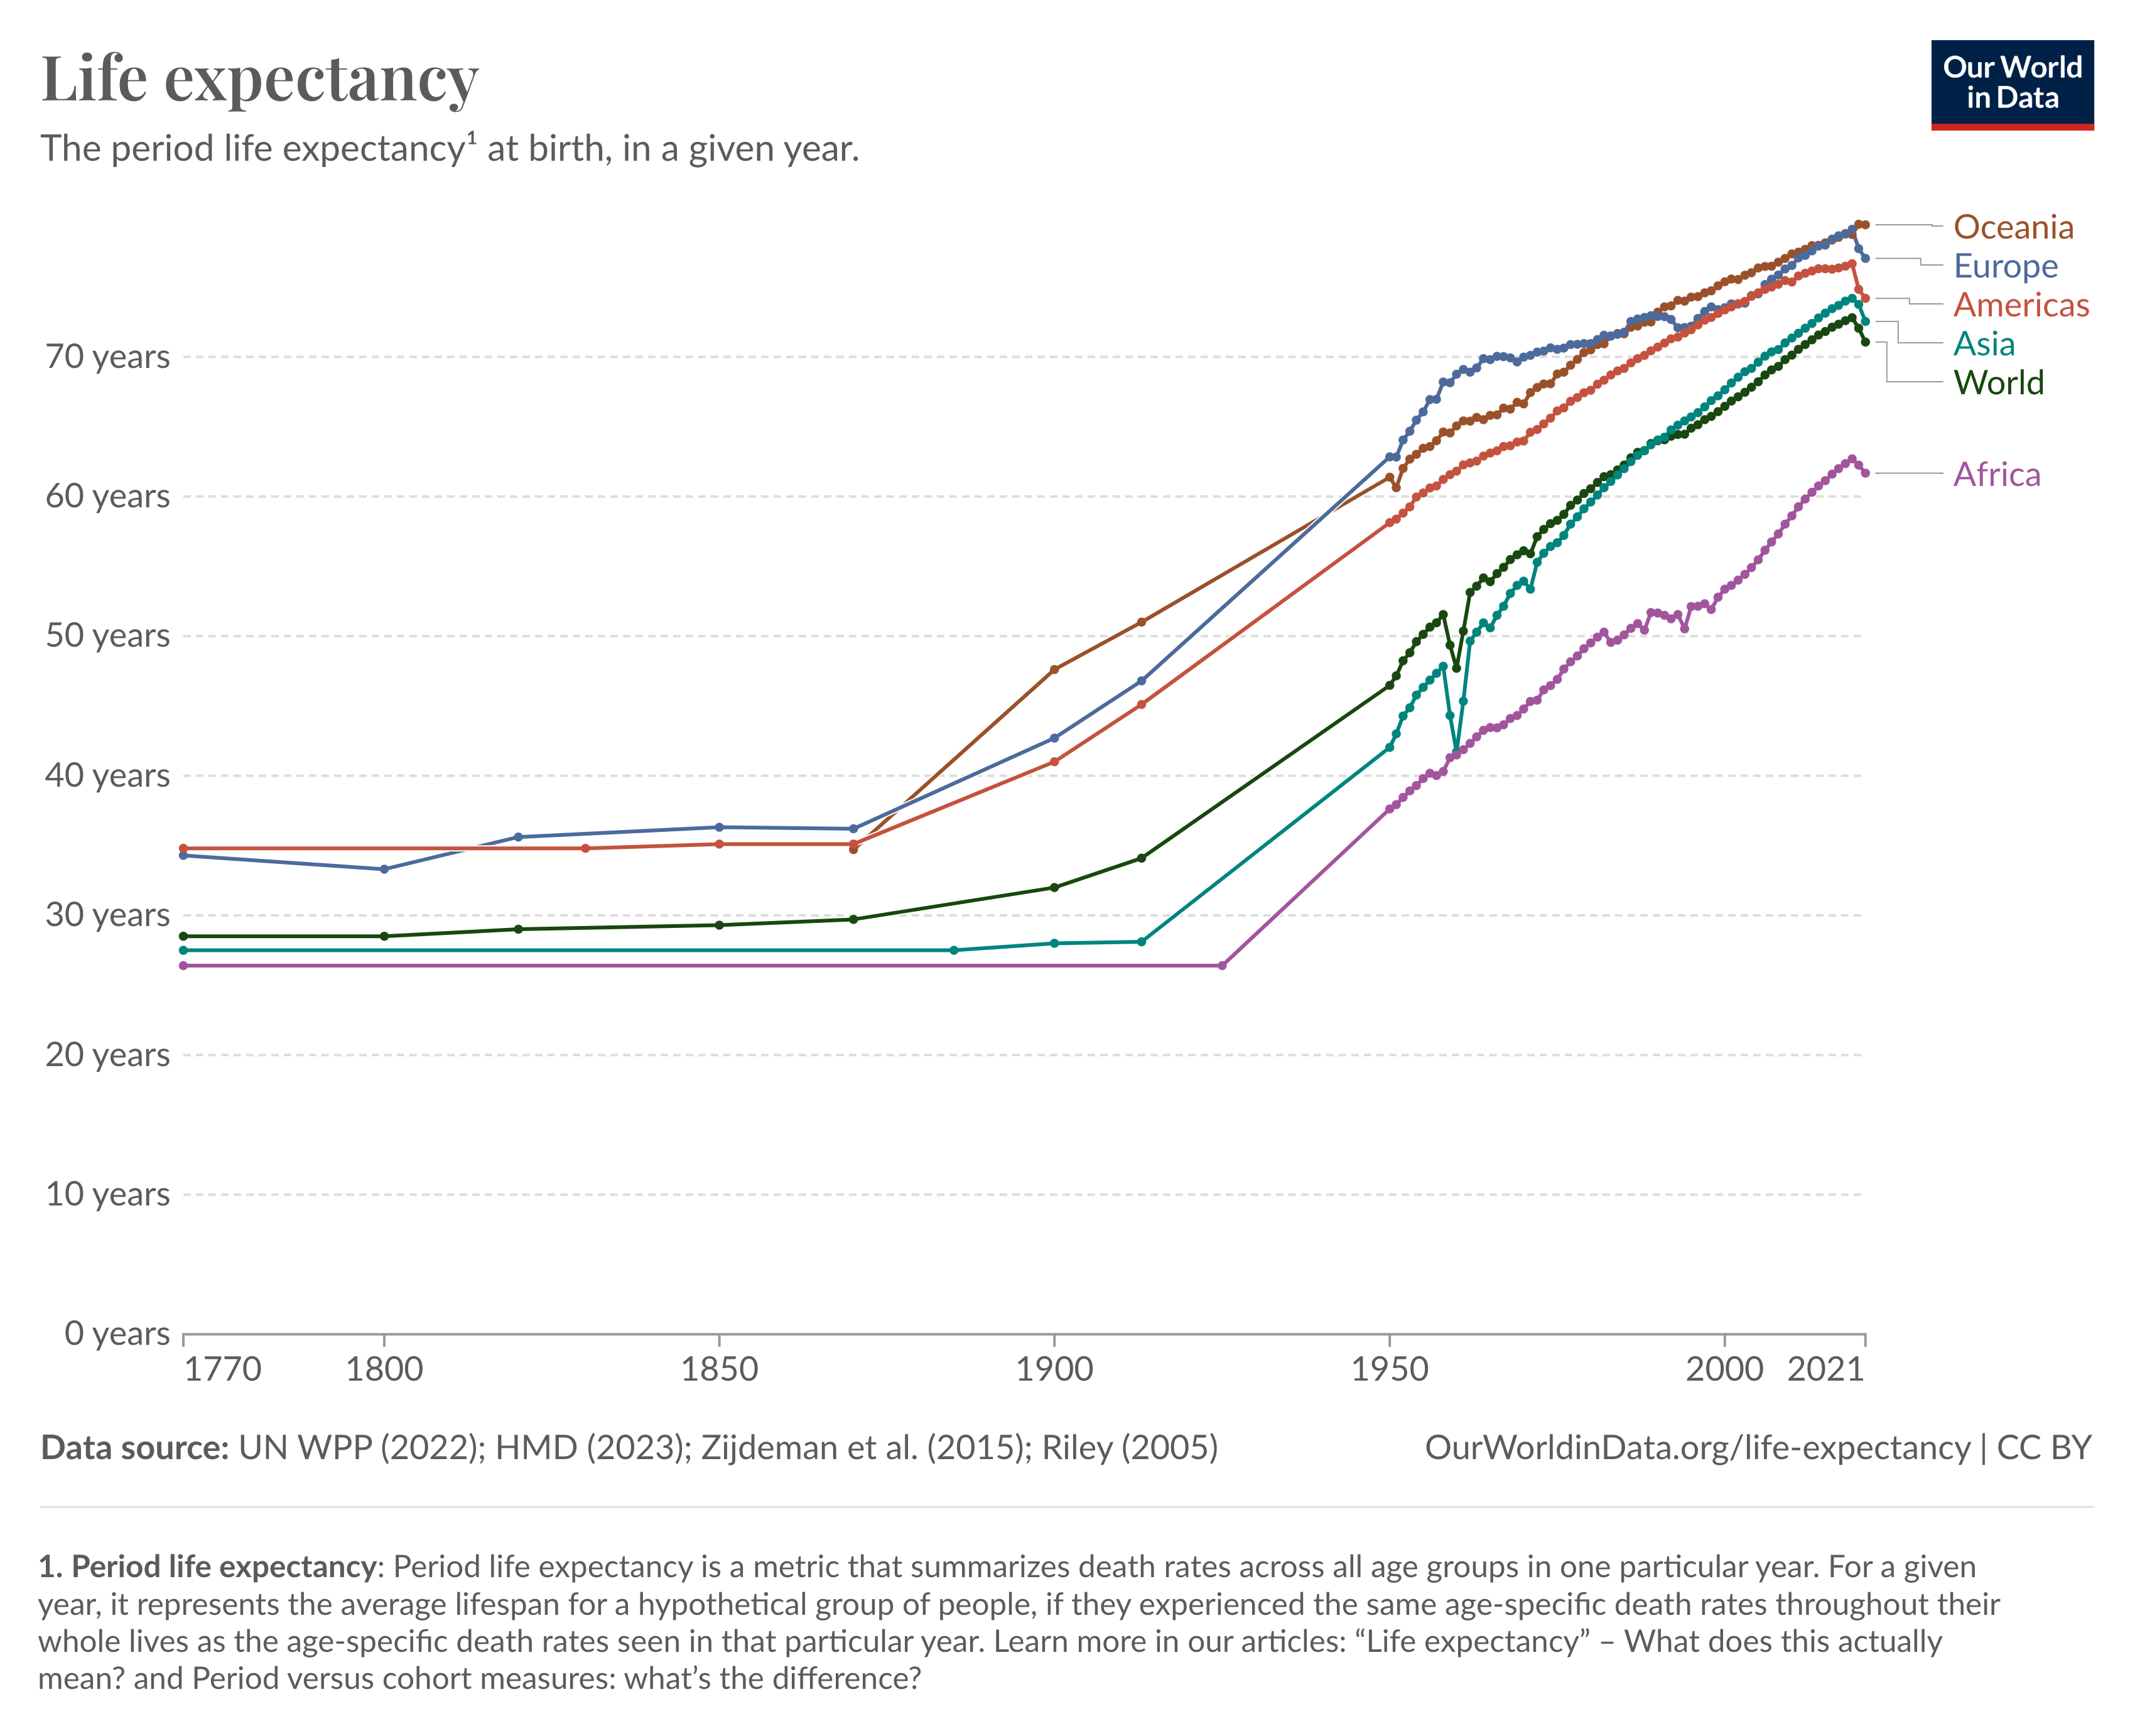

In [11]:
result_image = all_images[results[0]['doc_id']]
result_image

## 5. Initialize the Visual Language Model for Question Answering 🙋

Next, we’ll initialize the **Visual Language Model (VLM)** for question answering. For this task, we’ll be using **[SmolVLM](https://huggingface.co/HuggingFaceTB/SmolVLM-Instruct)**.

![SmolVLM architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/self_attention_architecture_smolvlm.png)

Stay up to date with the latest advancements in open vision language models by checking out the OpenVLMLeaderboard [here](https://huggingface.co/spaces/opencompass/open_vlm_leaderboard).

To get started, we’ll load the model from the pretrained checkpoint and transfer it to the GPU for optimal performance. You can explore the full model collection [here](https://huggingface.co/collections/HuggingFaceTB/smolvlm-6740bd584b2dcbf51ecb1f39).


In [ ]:
from transformers import Idefics3ForConditionalGeneration, AutoProcessor
import torch


model_id = "HuggingFaceTB/SmolVLM-Instruct"
vl_model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager",
)
vl_model.eval()

Next, we will initialize the Visual Language Model (VLM) processor.

In [ ]:
vl_model_processor = AutoProcessor.from_pretrained(model_id)

## 6. Assembling the VLM Model and Testing the System 🔧

With all components loaded, we are ready to assemble the system for testing. First, we’ll set up the chat structure by providing the system with the retrieved image and the user’s query. This step is highly customizable, offering flexibility to adjust the interaction according to your needs and enabling experimentation with different inputs and outputs.

In [12]:
chat_template = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": text_query
            },
        ],
    }
]

Now, let’s apply this chat template to set up the system for interacting with the model.


In [ ]:
text = vl_model_processor.apply_chat_template(
    chat_template, add_generation_prompt=True
)

Next, we will process the inputs to ensure they are properly formatted and ready for use with the Visual Language Model (VLM). This step is crucial for enabling the model to generate accurate responses based on the provided data.

In [15]:
inputs = vl_model_processor(
    text=text,
    images=[result_image],
    return_tensors="pt",
)
inputs = inputs.to("cuda")

We are now ready to generate the answer! Let’s see how the system uses the processed inputs to provide a response based on the user query and the retrieved images.

In [16]:
generated_ids = vl_model.generate(**inputs, max_new_tokens=500)

Once the model generates the output, we postprocess it to generate the final answer.

In [17]:
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = vl_model_processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

In [18]:
print(output_text[0])

 The overall trend in life expectancy across different countries and regions is an increase over time.


As we can see, the **SmolVLM** is able to answer the query correctly! 🎉

Now, let’s take a look at the memory consumption of the **SmolVLM** to understand its resource usage.

In [19]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 8.32 GB
GPU reserved memory: 10.38 GB


## 7. Assembling It All! 🧑‍🏭️

Now, let’s create a method that encompasses the entire pipeline, allowing us to easily reuse it in future applications.

In [16]:
def answer_with_multimodal_rag(vl_model, docs_retrieval_model, vl_model_processor, all_images, text_query, retrival_top_k, max_new_tokens):
    results = docs_retrieval_model.search(text_query, k=retrival_top_k)
    result_image = all_images[results[0]['doc_id']]

    chat_template = [
    {
      "role": "user",
      "content": [
          {"type": "image"},
          {"type": "text", "text": text_query}
        ],
      }
    ]

    # Prepare the inputs
    text = vl_model_processor.apply_chat_template(chat_template, add_generation_prompt=True)
    inputs = vl_model_processor(
        text=text,
        images=[result_image],
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    # Generate text from the vl_model
    generated_ids = vl_model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    # Decode the generated text
    output_text = vl_model_processor.batch_decode(
        generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
    )

    return output_text

Let’s take a look at how the complete RAG system operates!


In [21]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    all_images=all_images,
    text_query='What is the overall trend in life expectancy across different countries and regions?',
    retrival_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

 The overall trend in life expectancy across different countries and regions is an increase over time.


🏆 We now have a fully operational **smol RAG pipeline** that integrates both a **smol Document Retrieval Model** and a **smol Visual Language Model**, optimized to run on a single consumer GPU! This powerful combination allows us to generate insightful responses based on user queries and relevant documents, delivering a seamless multimodal experience.

## 8. Can We Go Smoler? 🤏

We now have a fully operational system, but can we go **smoler**? The answer is yes! We’ll use a quantized version of the **SmolVLM** model to further reduce the system’s resource requirements.

To fully experience the difference in consumption, I recommend reinitializing the system and running all cells, except for the ones that instantiate the VLM model. This way, you can clearly observe the impact of using the quantized model.

Let’s begin by installing [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index).


In [ ]:
!pip install -q -U bitsandbytes

Let's create the **BitsAndBytesConfig** configuration to load our model in a quantized **int-4** configuration, which will help reduce the model's memory footprint and improve performance.

In [2]:
from transformers import BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

Next, we can load the model using the quantization configuration we just created:

In [ ]:
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"
vl_model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    _attn_implementation="eager",
    device_map="auto"
)

In [ ]:
vl_model_processor = AutoProcessor.from_pretrained(model_id)

Finally, let’s test the capabilities of our quantized model:

In [17]:
output_text = answer_with_multimodal_rag(
    vl_model=vl_model,
    docs_retrieval_model=docs_retrieval_model,
    vl_model_processor=vl_model_processor,
    all_images=all_images,
    text_query='What is the overall trend in life expectancy across different countries and regions?',
    retrival_top_k=1,
    max_new_tokens=500
)
print(output_text[0])

 The overall trend in life expectancy across different countries and regions is an increase over time.


The model is working correctly! 🎉 Now, let's take a look at the memory consumption. Below, you can see the results — we've successfully reduced memory usage even further! 🚀

In [18]:
print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

GPU allocated memory: 5.44 GB
GPU reserved memory: 7.86 GB


Below is a table comparing the memory consumption of two other multimodal RAG notebooks in the [Cookbook](https://huggingface.co/learn/cookbook/) alongside the two versions described here. As you can see, these systems are an order of magnitude smaller in terms of resource requirements compared to the others.

| Notebook                                                                                     | GPU Allocated Memory (GB) | GPU Reserved Memory (GB) |
|---------------------------------------------------------------------------------------------|---------------------------|--------------------------|
| Smol Multimodal RAG with Quantization                                                       | 5.44 GB                   | 7.86 GB                  |
| Smol Multimodal RAG                                                                         | 8.32 GB                   | 10.38 GB                 |
| [Multimodal RAG with ColQwen2, Reranker, <br> and Quantized VLMs on Consumer GPUs](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_reranker_and_vlms) | 13.93 GB                  | 14.59 GB                 |
| [Multimodal RAG with Document Retrieval (ColPali) <br> and Vision Language Models (VLMs)](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms)  | 22.63 GB                  | 37.16 GB                 |




## 8. Continuing the Journey 🧑‍🎓️

If you're excited to keep exploring, be sure to check out the results and insights in the conclusion of our previous guide, [**Multimodal Retrieval-Augmented Generation (RAG) with Document Retrieval (ColPali) and Vision Language Models (VLMs)**](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_vlms), as well as the reranker guide, [**Multimodal RAG with ColQwen2, Reranker, and Quantized VLMs on Consumer GPUs**](https://huggingface.co/learn/cookbook/multimodal_rag_using_document_retrieval_and_reranker_and_vlms).

Happy experimenting! 🧑‍🔬

